# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 2

# Preliminary operations 

## Import needed libraries

In [1]:
# import needed python libraries

%matplotlib inline

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from itertools import product

## Data preparation & standardization

In [2]:
columns_to_remove = ['Active Mean', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size',
                     'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                     'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s',
                     'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total',
                     'Fwd PSH Flags', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean',
                     'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
                     'Protocol', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets',
                     'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0)
ddos_data = ddos_data.drop(columns=columns_to_remove, errors='ignore')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1. Perform a split to segment the dataset into training and test dataset, in a stratified way with respect to the labels

In [3]:
# Prepare the dataset extracting Features (X) and Labels (Y) 
# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set
ddos_data_copy = ddos_data.copy()

ddos_data_copy['label'] = pd.Categorical(ddos_data_copy['label']).codes  # transform to numerical labels
ddos_data_copy.drop(columns=["Unnamed: 0", "Flow ID", "Destination IP", "Source IP", "Timestamp", "SimillarHTTP"],
                    axis=1, inplace=True)

x = ddos_data_copy.drop(columns=['label']).to_numpy()
y = ddos_data_copy[['label']].to_numpy()

# Run stratified training-test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.7, random_state=15)

# This line is used to flatten the labels (which might be in a two-dimensional array) into one-dimensional arrays. 
# This is often necessary for compatibility with certain machine learning algorithms that expect 1D arrays for labels.

y_train, y_test = np.ravel(y_train), np.ravel(y_test)

# Standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_s, x_test_s = scaler.transform(x_train), scaler.transform(x_test)

#PCA
pca = PCA(n_components=0.95)  # Adjust n_components as needed
x_train_s = pca.fit_transform(x_train_s)
x_test_s = pca.transform(x_test_s)

# 2. Choose at least 3 ML methods, and perform the model training, with default parameter configuration, evaluating the performance on both training and test set. Output the confusion matrix and classification report. Do you observe overfitting or under-fitting? 

## 2 Models Training

In [4]:
# Initialize the models with default parameters
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)

# Train the models on the training data
decision_tree.fit(x_train_s, y_train)
random_forest.fit(x_train_s, y_train)
logistic_regression.fit(x_train_s, y_train)

# Evaluate the models on the training set
y_train_pred_dt = decision_tree.predict(x_train_s)
y_train_pred_rf = random_forest.predict(x_train_s)
y_train_pred_lr = logistic_regression.predict(x_train_s)

# Evaluate the models on the test set
y_test_pred_dt = decision_tree.predict(x_test_s)
y_test_pred_rf = random_forest.predict(x_test_s)
y_test_pred_lr = logistic_regression.predict(x_test_s)


## 2 Output the confusion matrix and classification report

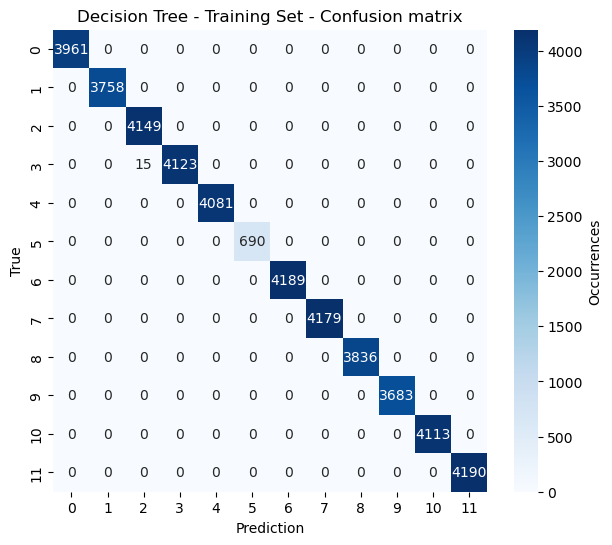

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       1.00      1.00      1.00      3758
           2       1.00      1.00      1.00      4149
           3       1.00      1.00      1.00      4138
           4       1.00      1.00      1.00      4081
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       1.00      1.00      1.00      4179
           8       1.00      1.00      1.00      3836
           9       1.00      1.00      1.00      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967



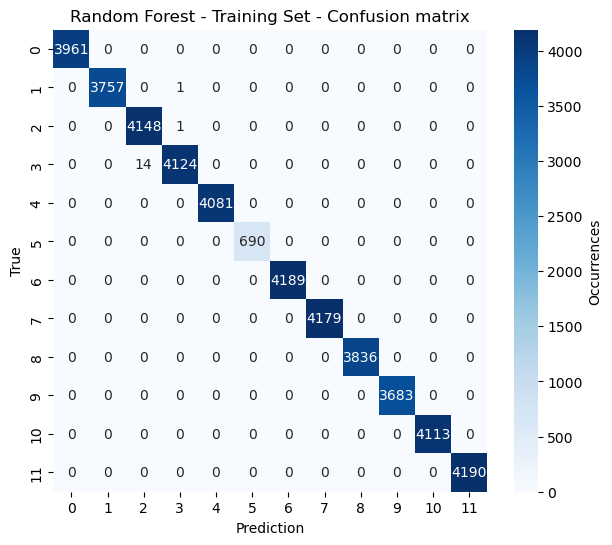

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       1.00      1.00      1.00      3758
           2       1.00      1.00      1.00      4149
           3       1.00      1.00      1.00      4138
           4       1.00      1.00      1.00      4081
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       1.00      1.00      1.00      4179
           8       1.00      1.00      1.00      3836
           9       1.00      1.00      1.00      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967



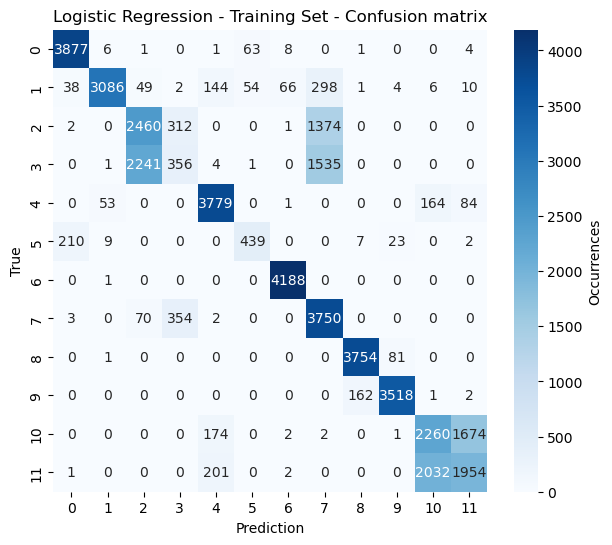

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3961
           1       0.98      0.82      0.89      3758
           2       0.51      0.59      0.55      4149
           3       0.35      0.09      0.14      4138
           4       0.88      0.93      0.90      4081
           5       0.79      0.64      0.70       690
           6       0.98      1.00      0.99      4189
           7       0.54      0.90      0.67      4179
           8       0.96      0.98      0.97      3836
           9       0.97      0.96      0.96      3683
          10       0.51      0.55      0.53      4113
          11       0.52      0.47      0.49      4190

    accuracy                           0.74     44967
   macro avg       0.74      0.74      0.73     44967
weighted avg       0.73      0.74      0.73     44967



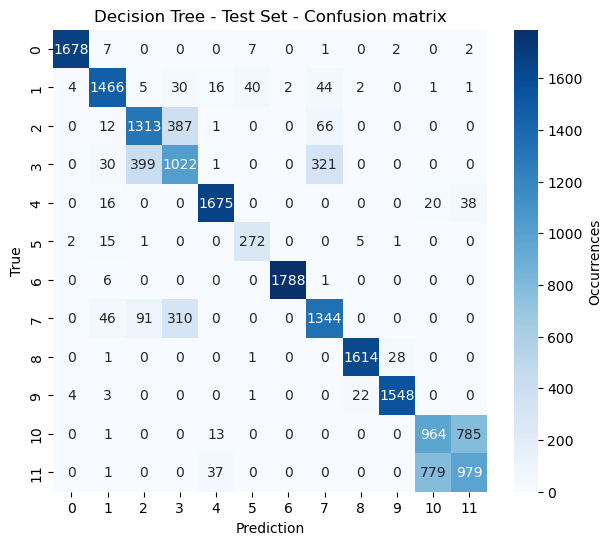

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1697
           1       0.91      0.91      0.91      1611
           2       0.73      0.74      0.73      1779
           3       0.58      0.58      0.58      1773
           4       0.96      0.96      0.96      1749
           5       0.85      0.92      0.88       296
           6       1.00      1.00      1.00      1795
           7       0.76      0.75      0.75      1791
           8       0.98      0.98      0.98      1644
           9       0.98      0.98      0.98      1578
          10       0.55      0.55      0.55      1763
          11       0.54      0.55      0.54      1796

    accuracy                           0.81     19272
   macro avg       0.82      0.82      0.82     19272
weighted avg       0.81      0.81      0.81     19272



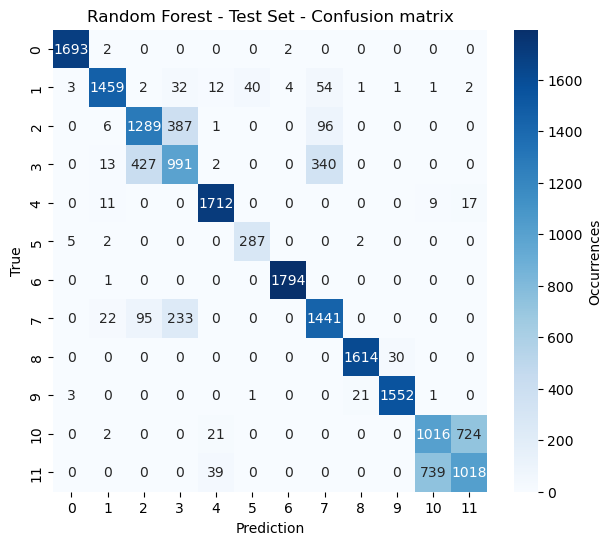

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1697
           1       0.96      0.91      0.93      1611
           2       0.71      0.72      0.72      1779
           3       0.60      0.56      0.58      1773
           4       0.96      0.98      0.97      1749
           5       0.88      0.97      0.92       296
           6       1.00      1.00      1.00      1795
           7       0.75      0.80      0.77      1791
           8       0.99      0.98      0.98      1644
           9       0.98      0.98      0.98      1578
          10       0.58      0.58      0.58      1763
          11       0.58      0.57      0.57      1796

    accuracy                           0.82     19272
   macro avg       0.83      0.84      0.83     19272
weighted avg       0.82      0.82      0.82     19272



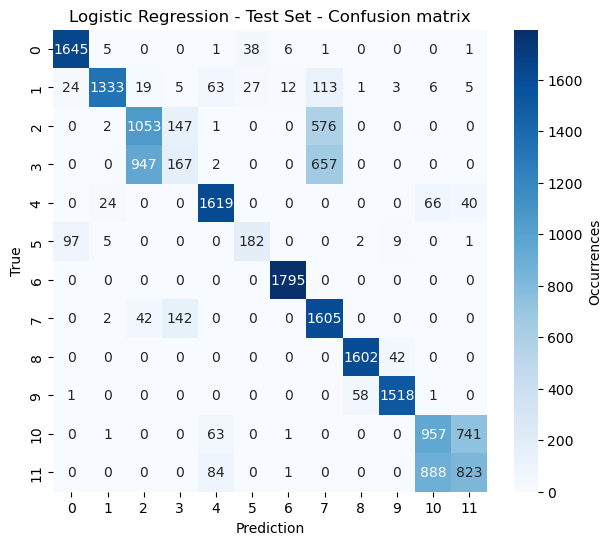

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1697
           1       0.97      0.83      0.89      1611
           2       0.51      0.59      0.55      1779
           3       0.36      0.09      0.15      1773
           4       0.88      0.93      0.90      1749
           5       0.74      0.61      0.67       296
           6       0.99      1.00      0.99      1795
           7       0.54      0.90      0.68      1791
           8       0.96      0.97      0.97      1644
           9       0.97      0.96      0.96      1578
          10       0.50      0.54      0.52      1763
          11       0.51      0.46      0.48      1796

    accuracy                           0.74     19272
   macro avg       0.74      0.74      0.73     19272
weighted avg       0.73      0.74      0.72     19272



In [5]:
def plot_confusion_matrix_and_report(y_true, y_pred, model_name, dataset_type):
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, cbar_kws={'label': 'Occurrences'}, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{model_name} - {dataset_type} - Confusion matrix')
    plt.show()
    print(classification_report(y_true, y_pred))

plot_confusion_matrix_and_report(y_train, y_train_pred_dt, 'Decision Tree', 'Training Set')
plot_confusion_matrix_and_report(y_train, y_train_pred_rf, 'Random Forest', 'Training Set')
plot_confusion_matrix_and_report(y_train, y_train_pred_lr, 'Logistic Regression', 'Training Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_dt, 'Decision Tree', 'Test Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_rf, 'Random Forest', 'Test Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_lr, 'Logistic Regression', 'Test Set')

There is overfitting in the training set.

# 3. Tune the hyper-parameters of the models through cross-validation. How do performance vary? Which model generates the best performance?

## Data preparation

In [ ]:
x_train_htuning, x_val_htuning, y_train_htuning, y_val_htuning = train_test_split(x, y, stratify=y, train_size=5 / 7, random_state=42)

# Standardize data and PCA
scaler_h = StandardScaler()
x_train_htuning_s = scaler_h.fit_transform(x_train_htuning)
pca = PCA(n_components=0.95)  # Adjust n_components as needed
x_train_htuning_s = pca.fit_transform(x_train_htuning_s)
x_val_htuning_s = pca.transform(scaler_h.transform(x_val_htuning))


y_train_htuning, y_val_htuning = np.ravel(y_train_htuning) , np.ravel(y_val_htuning)

## First approach (No Library functions)

In [7]:
def train_and_evaluate(criterion, max_depth, min_samples_split, x_train, y_train, x_val, y_val):
    dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    dt.fit(x_train, y_train)
    return accuracy_score(y_train, dt.predict(x_train)), accuracy_score(y_val, dt.predict(x_val))

In [8]:
# Hyperparameters
criterions = ['gini', 'entropy']
max_depths = [4, 6, 8, None]
min_samples_splits = [2, 3, 4]

best_combination = None
best_mean_acc = 0

train_accs, val_accs = [], []

for criterion, max_depth, min_samples_split in product(criterions, max_depths, min_samples_splits):
    train_acc, val_acc = train_and_evaluate(criterion, max_depth, min_samples_split, x_train_htuning_s, y_train_htuning, x_val_htuning_s, y_val_htuning)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    mean_val_acc = np.mean(val_accs)
    if mean_val_acc >= best_mean_acc:
        best_mean_acc = mean_val_acc
        best_combination = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}

print('Best Hyperparameters:', best_combination)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 4}


In [9]:
# test best model
dt_final = DecisionTreeClassifier(
    criterion=best_combination['criterion'],
    max_depth=best_combination['max_depth'],
    min_samples_split=best_combination['min_samples_split'],
    random_state=42
)
dt_final.fit(x_train_htuning_s, y_train_htuning)
y_pred_htuning = dt_final.predict(x_val_htuning_s)

# Classification report
print(classification_report(y_val_htuning, y_pred_htuning))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1616
           1       0.89      0.92      0.90      1534
           2       0.71      0.76      0.74      1694
           3       0.59      0.56      0.58      1689
           4       0.96      0.96      0.96      1665
           5       0.90      0.86      0.88       282
           6       1.00      1.00      1.00      1710
           7       0.74      0.72      0.73      1706
           8       0.98      0.98      0.98      1566
           9       0.98      0.98      0.98      1503
          10       0.54      0.54      0.54      1679
          11       0.55      0.54      0.54      1710

    accuracy                           0.81     18354
   macro avg       0.82      0.82      0.82     18354
weighted avg       0.81      0.81      0.81     18354



## Second approach (With library functions)

In [10]:
# Definition of the hyperparameter grid to be tested
param_grid_decision_tree = {
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Creation of the GridSearchCV object
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid_decision_tree, cv=5, scoring='accuracy')

# Execution of the grid search
grid_search.fit(x_train_htuning_s, y_train_htuning)

# Print the best hyperparameters and their accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Evaluation of the optimized model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(x_val_htuning_s, y_val_htuning)
print("Accuracy on the test set:", test_accuracy)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 3}
Best accuracy: 0.803813882532418
Accuracy on the test set: 0.8071265119320039


In [17]:
# Define a function for grid search
def grid_search(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(x_train_htuning_s, y_train_htuning)
    best_model = grid_search.best_estimator_
    accuracy = best_model.score(x_val_htuning_s, y_val_htuning)
    return best_model, accuracy

In [ ]:
# Questo pezzo di codice è temporaneo. Aspettiamo ancora un secondo prima di...

# Decision Tree hyperparameters
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Logistic Regression hyperparameters
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Perform grid search for each model
dt_model, dt_accuracy = grid_search(DecisionTreeClassifier(random_state=42), dt_params)
rf_model, rf_accuracy = grid_search(RandomForestClassifier(random_state=42), rf_params)
lr_model, lr_accuracy = grid_search(LogisticRegression(random_state=42), lr_params)

# Print the best models and their accuracies
print(f"Decision Tree accuracy: {dt_accuracy}")
print(f"Random Forest accuracy: {rf_accuracy}")
print(f"Logistic Regression accuracy: {lr_accuracy}")

# Determine the best overall model
best_accuracy = max(dt_accuracy, rf_accuracy, lr_accuracy)
best_model = 'Decision Tree' if best_accuracy == dt_accuracy else 'Random Forest' if best_accuracy == rf_accuracy else 'Logistic Regression'

print(f"Best model: {best_model} with accuracy {best_accuracy}")

# 4. Investigate the False Positive and False Negative. Can you draw considerations about the misclassification in terms of features? Report your analysis and findings for the ones you consider the most notable samples. 